<a href="https://colab.research.google.com/github/open-pack/openpack-torch/blob/main/examples/notebooks/U-Net_Train-Model-and-Make-Submission-File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net | Train Model and Make Submission File

This is a tutorial of [OpenPack Challenge 2022](https://open-pack.github.io/challenge2022/).
In this notebook, we will build the U-Net, one of the basic architecture for segmentation, with the acceleration data from the left wrist (atr02). This notebook also shows how to make submission file (`submission.json`) for OpenPack Challenge 2022. In fact, the performance of this U-Net is poor. Please enjoy finding a better architecture and parameters.

**NOTE: When you run this notebook in colab, please change runtime to GPU first.**

In [ ]:
import torch

if not torch.cuda.is_available():
    raise ValueError("Change notebook runtime to GPU !")

## [0] Inital Setup

### 0-1: Download Code and Install `openpack-torch`
NOTE: You can also install `openpack-torch` from PyPI with `pip install openpack-torch`.

In [ ]:
! cd /content && git clone https://github.com/open-pack/openpack-torch.git

Cloning into 'openpack-torch'...
remote: Enumerating objects: 1249, done.
remote: Counting objects: 100% (418/418), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 1249 (delta 125), reused 342 (delta 99), pack-reused 831
Receiving objects: 100% (1249/1249), 55.48 MiB | 23.45 MiB/s, done.
Resolving deltas: 100% (482/482), done.


In [ ]:
! pip install openpack-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 39.9 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=1c9d40aad1af237b7c44d5a635c60f7bb49d7c3fa9467941d3f2ddb1985a8ba0
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


### 0-2: Download Dataset to Your Google Drive
Follow the instruction of [Tutorial - Download OpenPack Dataset to Google Drive.ipynb](https://colab.research.google.com/drive/1YOnegl9L6UnlfermwJpevWLQ43anwwGd?usp=drive_link) to download OpenPack Dataset (v1.0.0) to your Google Drive.

After you finish downloading the datasets, mount your Google Drive to this notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Create shortcut to the dataset directory with `ln -s`.

In [ ]:
! ln -s "/content/drive/MyDrive/Colab Notebooks/openpack/data/" "/content/data"

In [ ]:
! ls -la "/content/data/datasets/openpack/v1.0.0"

total 92
drwx------ 2 root root 4096 Feb  3 09:55 preprocessed
drwx------ 2 root root 4096 Feb  3 09:56 U0101
drwx------ 2 root root 4096 Feb  3 09:56 U0102
drwx------ 2 root root 4096 Feb  3 09:56 U0103
drwx------ 2 root root 4096 Feb  3 09:56 U0104
drwx------ 2 root root 4096 Feb  3 09:56 U0105
drwx------ 2 root root 4096 Feb  3 09:56 U0106
drwx------ 2 root root 4096 Feb  3 09:57 U0107
drwx------ 2 root root 4096 Feb  3 09:57 U0108
drwx------ 2 root root 4096 Feb  3 09:57 U0109
drwx------ 2 root root 4096 Feb  3 09:57 U0110
drwx------ 2 root root 4096 Feb  3 09:57 U0111
drwx------ 2 root root 4096 Feb  3 09:57 U0201
drwx------ 2 root root 4096 Feb  3 09:58 U0202
drwx------ 2 root root 4096 Feb  3 09:58 U0203
drwx------ 2 root root 4096 Feb  3 09:58 U0204
drwx------ 2 root root 4096 Feb  3 09:58 U0205
drwx------ 2 root root 4096 Feb  3 09:58 U0206
drwx------ 2 root root 4096 Feb  3 09:58 U0207
drwx------ 2 root root 4096 Feb  3 09:58 U0208
drwx------ 2 root root 4096 Feb  3 09:59 U02

### 0-3: Import Modules

In [ ]:
import logging
from logging import getLogger
from pathlib import Path
from typing import Dict, Optional

import hydra
import openpack_toolkit as optk
import pytorch_lightning as pl
import torch
import pandas as pd
import numpy as np
from omegaconf import DictConfig, OmegaConf
from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns

import openpack_torch as optorch
from openpack_torch.lightning import EarlyStopError
from openpack_torch.utils.test_helper import test_helper

from openpack_toolkit import ActSet
from openpack_toolkit.configs.datasets.annotations import (
    OPENPACK_ACTIONS,
    OPENPACK_OPERATIONS,
)
from openpack_toolkit.codalab.operation_segmentation import (
    construct_submission_dict, eval_operation_segmentation_wrapper,
    make_submission_zipfile)

### 0-4: Setup Logger

In [ ]:
_ = optk.utils.notebook.setup_root_logger()
logger = logging.getLogger(__name__)

logger.debug("debug")
logger.info("info")
logger.warning("warning")

INFO:__main__:info
2024-02-04 06:55:00 | INFO | __main__ | info
2024-02-04 06:55:00 | WARNING | __main__ | warning


### 0-5: Set Random Seed

In machine learning, a lot of random variables are generated and it affect to model's performance.
By resetting a random seed before each run, you can improve reproducibility.

In [ ]:
optorch.utils.reset_seed(seed=0)

INFO:openpack_torch.utils.random:Reset Seeds: python=0, numpy=0, Pytorch (cpu=0, cuda=0)
2024-02-04 06:55:02 | INFO | openpack_torch.utils.random | Reset Seeds: python=0, numpy=0, Pytorch (cpu=0, cuda=0)


## [1] Load Config File

### 1-1: Overview of Config Files
Thare are a lot of parameters that are needed to train deep learning models. Managing these parameters is a laborious task.
Here are some useful tools to ease this burden. [hydra](https://hydra.cc/) is a framework for elegantly configurein complex application, and also you can use it to manage parameters.
To update default parameters, please update YAML files in [configs](https://github.com/open-pack/openpack-torch/tree/main/examples/unet/configs).
We will show you some examples here, but when you want to utilse yaml files, please refere to other tutorials.

#### Ex.1: Change Training Parameters

For example, when you want to change default `batch_size`, edit [unet.yaml](https://github.com/open-pack/openpack-torch/blob/main/examples/configs/unet.yaml) as follows.

```yaml
train:
  num_workers: 3
  batch_size: 128 # Updated (original value = 64)
  epochs:
    minimum: 300
    maximum: 1000
```

#### Ex.2: Change Input Modality

An another example is to add IMU sensors at left&right arm (atr03, atr04).
You can change it by editing [atr02-iot.yaml](https://github.com/open-pack/openpack-torch/blob/main/examples/configs/dataset/stream/atr02-iot.yaml)


```yaml
spec:
    imu:
        devices:
        - atr01
        - atr02 # Add
        - atr03 # Add
        - atr04 # Add
        acc: true
        gyro: false
        quat: false
```

### 1-2: Register Configs to Hydra in `openpack-torch`
First, register OpenPaack official configs to hydra.

In [ ]:
optorch.configs.register_configs()

### 1-3: Load Custom Configs
Load configuration files in [/content/openpack-torch/examples/unet/configs](https://github.com/open-pack/openpack-torch/blob/main/examples/unet/configs/operation-segmentation.yaml).
In this notebook, we will copy YAML files to the current directory and load default parameters from there.
You may want to change some default parameters, please save config files into your Google Drive and edit them.
For temporal changes such as learning rate, we can change them by `overrides` param in `hydra.compose()`.

In [ ]:
! cp -r /content/openpack-torch/examples/configs /content/

In [ ]:
overrides = [
    "mode=train",
    "metadata.labels.issue=I01-EXP1-V1-nb", # subdirectry for logging

    # -- debug --
    # If true, some training parameters (e.g., bach size, epochs) are switched to debug mode setting written in `train.debug.XXX`.
    "debug=true",

    # -- path.logdir.rootdir --
    "path.openpack.version=v1.0.0",
    "path.openpack.rootdir=/content/data/datasets/openpack/${path.openpack.version}/",

    # -- path.logdir.rootdir --
    # path to write training logs and resutls.
    # If you want to keep logs, please use Google Drive (i.e., `/content/data/XXX` (symling to Google Drive), `/content/drive/XXX`)
    "path.logdir.rootdir=/content/data/log/${metadata.name}/${metadata.labels.issue}/${metadata.task}/${dataset.split.name}-split/${dataset.stream.name}/${model.name}/${metadata.labels.params}/RUN${run}",

    # "hydra/job_logging=custom",
    # "hydra/hydra_logging=disabled"
]

with hydra.initialize_config_dir(version_base=None, config_dir="/content/configs"):
    cfg = hydra.compose(
        config_name="unet.yaml",
        overrides=overrides,
    )

# -- Data Split --
# Change Train/Val/Test/Submission set to submit for Development Phase.
# Please comment out the following block when you want to train on the main set.
cfg.dataset.split = optk.configs.datasets.splits.DEBUG_SPLIT

# (default value)
# cfg.dataset.split = optk.configs.datasets.splits.OPENPACK_CHALLENGE_2022_SPLIT

In [ ]:
print(OmegaConf.to_yaml(cfg))

run: 0
debug: true
mode: train
path:
  openpack:
    version: v1.0.0
    rootdir: /content/data/datasets/openpack/${path.openpack.version}/
  datasets:
    openpack: ${path.openpack.rootdir}
  logdir:
    rootdir: /content/data/log/${metadata.name}/${metadata.labels.issue}/${metadata.task}/${dataset.split.name}-split/${dataset.stream.name}/${model.name}/${metadata.labels.params}/RUN${run}
    model: ${path.logdir.rootdir}/model.pth
    predict: ${path.logdir.rootdir}/pred/${train.checkpoint}/{user}-{session}
    summary:
      rootdir: ${path.logdir.rootdir}/summary/${train.checkpoint}
      train: ${.rootdir}/train.csv
      test: ${.rootdir}/test.csv
      test-b2: ${.rootdir}/test-b2.csv
      test-b3: ${.rootdir}/test-b3.csv
      submission: ${.rootdir}/submission.csv
dataset:
  annotation:
    kind: dataset/annotation/csv/sequence
    name: openpack-operations-1hz-annotation
    metadata:
      labels:
        type: annotation/operation
        version: v3.5.0
        dependency:

## [2] Define Utilities (Pytorch Lightning Modules)

### 2-1: DataModule

Define a new DataModule class (e.g., `OpenPackImuDataModule`) and  set [`optorch.data.datasets.OpenPackImu`](https://github.com/open-pack/openpack-torch/blob/main/openpack_torch/data/datasets.py) to `dataset_class`.
When you implement custom dataset, set your dataset class to `dataset_class`.

Paramters to initialize the dataset class should be prepared in `get_kwargs_form_datasets()` method.
The dataset class is initialized with`kwargs`, an output of `get_kwargs_form_datasets()`, as follows.

```python
# https://github.com/open-pack/openpack-torch/blob/6c6933e24c7c3311e582ebf3aac1a659467be0fb/openpack_torch/data/datamodule.py#L91
self.op_train = self.dataset_class(self.cfg, split.train, **kwargs)
```

In [ ]:
class OpenPackImuDataModule(optorch.data.OpenPackBaseDataModule):
    dataset_class = optorch.data.datasets.OpenPackImu

    def get_kwargs_for_datasets(self, stage: Optional[str] = None) -> Dict:
        kwargs = {
            "window": self.cfg.train.window,
            "debug": self.cfg.debug,
        }
        return kwargs

### 2-2: Lightning Module

In the `init_model()` method, you can initialize your model.

In the `init_criterion()` method, you can register your custom loss function.
But make sure that ignore classes are excluded from evaluation process.
For `torch.nn.CrossEntropyLoss`, you can use `ignore_class` parameter.

In [ ]:
class UNetLM(optorch.lightning.BaseLightningModule):
    def init_model(self, cfg: DictConfig) -> torch.nn.Module:
        dim = 0
        if self.cfg.dataset.stream.spec.imu.acc:
            dim += 3
        if self.cfg.dataset.stream.spec.imu.gyro:
            dim += 3
        if self.cfg.dataset.stream.spec.imu.quat:
            dim += 4

        input_dim = len(self.cfg.dataset.stream.spec.imu.devices) * dim
        output_dim = len(self.cfg.dataset.annotation.spec.classes)
        model = optorch.models.imu.UNet(
            input_dim,
            output_dim,
            depth=cfg.model.spec.depth,
        )
        return model

    def train_val_common_step(self, batch: Dict, batch_idx: int) -> Dict:
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        y_hat = self(x).squeeze(3)

        loss = self.criterion(y_hat, t)
        acc = self.calc_accuracy(y_hat, t)
        return {"loss": loss, "acc": acc}

    def test_step(self, batch: Dict, batch_idx: int) -> Dict:
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        ts_unix = batch["ts"]

        y_hat = self(x).squeeze(3)

        outputs = dict(t=t, y=y_hat, unixtime=ts_unix)
        self.test_step_outputs.append(outputs)
        return outputs


## [3] Train U-Net

### 3-1: Initialize U-Net Model and DataLoader.

In [ ]:
device = torch.device("cuda")
logdir = Path(cfg.path.logdir.rootdir)
logger.debug(f"logdir = {logdir}")

datamodule = OpenPackImuDataModule(cfg)
plmodel = UNetLM(cfg).to(dtype=torch.float, device=device)

In [ ]:
plmodel

UNetLM(
  (net): UNet(
    (inc): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (encoder): UNetEncoder(
      (0): ModuleList(
        (0): DownBlock(
          (double_conv): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
            (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU()
          )
          (pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
        )
        (1): DownBlock(
          (double_conv): Sequential(
            (0): Conv2d(32, 64, kernel_size=(3, 1), strid

### 3-2: Initialize Trainer

In [ ]:
max_epoch = (
    cfg.train.debug.epochs.maximum if cfg.debug else cfg.train.epochs.maximum
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=1,
    save_last=True,
    mode=cfg.train.early_stop.mode,
    monitor=cfg.train.early_stop.monitor,
    filename="{epoch:02d}-{train/loss:.2f}-{val/loss:.2f}",
    verbose=False,
)

early_stop_callback = pl.callbacks.EarlyStopping(
    **cfg.train.early_stop,
)

pl_logger = pl.loggers.CSVLogger(logdir)
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    min_epochs=1,
    max_epochs=max_epoch,
    logger=pl_logger,
    default_root_dir=logdir,
    enable_progress_bar=True,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=4,
)
logger.debug(f"logdir = {logdir}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
2024-02-04 06:55:22 | INFO | pytorch_lightning.utilities.rank_zero | GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
2024-02-04 06:55:22 | INFO | pytorch_lightning.utilities.rank_zero | TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
2024-02-04 06:55:22 | INFO | pytorch_lightning.utilities.rank_zero | IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
2024-02-04 06:55:22 | INFO | pytorch_lightning.utilities.rank_zero | HPU available: False, using: 0 HPUs


### 3-3: Start training!

In [ ]:
logger.info(f"Start training for {max_epoch} epochs.")
try:
    trainer.fit(plmodel, datamodule)
except EarlyStopError as e:
    logger.warning(e)
logger.info(f"Finish training! (logdir = {logdir})")

INFO:__main__:Start training for 10 epochs.
2024-02-04 06:55:24 | INFO | __main__ | Start training for 10 epochs.
2024-02-04 06:55:24 | WARNING | lightning_fabric.loggers.csv_logs | Missing logger folder: /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/RUN0/lightning_logs
INFO:openpack_torch.data.datamodule:dataset[train]: OpenPackImu(index=129, num_sequence=3, submission=False, random_crop=True)
2024-02-04 06:55:28 | INFO | openpack_torch.data.datamodule | dataset[train]: OpenPackImu(index=129, num_sequence=3, submission=False, random_crop=True)
INFO:openpack_torch.data.datamodule:dataset[val]: {'U0102-S0400': <openpack_torch.data.datasets.OpenPackImu object at 0x7c5ae179ce20>}
2024-02-04 06:55:28 | INFO | openpack_torch.data.datamodule | dataset[val]: {'U0102-S0400': <openpack_torch.data.datasets.OpenPackImu object at 0x7c5ae179ce20>}
INFO:openpack_torch.data.datamodule:dataset[test]: None
2024-02-04 06:55:28 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
2024-02-04 06:55:50 | INFO | pytorch_lightning.utilities.rank_zero | `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:__main__:Finish training! (logdir = /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/RUN0)
2024-02-04 06:55:50 | INFO | __main__ | Finish training! (logdir = /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/RUN0)


### 3-4: Plot Training Curve

Training logs are stored in `plmodel.log` (dict). Let's visualize training curves for training and validation set.

In [ ]:
pl_logdir = Path(cfg.path.logdir.rootdir, "lightning_logs/")
latest_logdir = list(sorted(pl_logdir.iterdir()))[-1]

df = pd.read_csv(Path(latest_logdir, "metrics.csv"))
df["phase"] = df["train/loss"].apply(lambda x: "val" if np.isnan(x) else "train")
df = df.set_index(["epoch", "phase"])

In [ ]:
df.head()

val/acc  val/loss  step  train/loss  train/acc
epoch phase                                                 
0     val    0.082268  2.387441    16         NaN        NaN
      train       NaN       NaN    16    2.211711   0.269642
1     val    0.181134  2.343647    33         NaN        NaN
      train       NaN       NaN    33    2.002056   0.341471
2     val    0.245270  2.128481    50         NaN        NaN

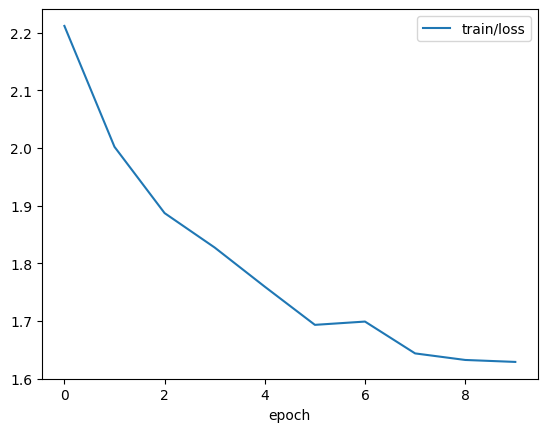

In [ ]:
df.xs("train", level="phase")[["train/loss"]].plot()
plt.show()

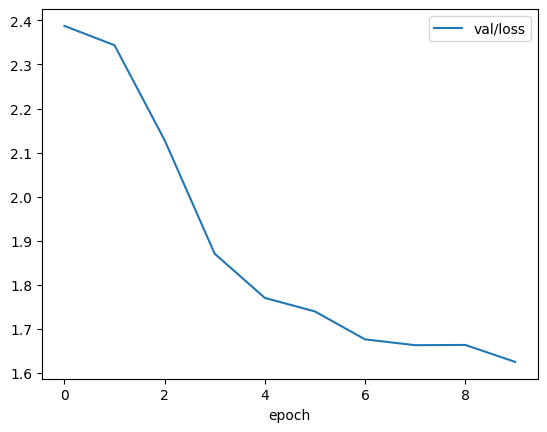

In [ ]:
df.xs("val", level="phase")[["val/loss"]].plot()
plt.show()

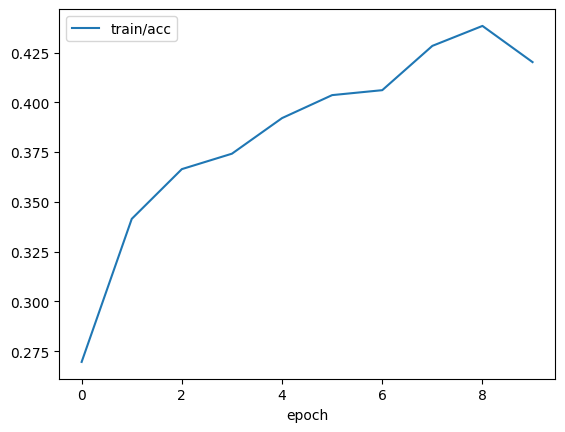

In [ ]:
df.xs("train", level="phase")[["train/acc"]].plot()
plt.show()

## [4] Test

Evaluation function is defined in `optk.codalab.eval_operation_segmentation_wrapper()`. This function takes dict as the 2nd argument and prediction (`y`), groundtruth (`t_idx`; activity class index) and corresponding unixtime (`unixtime`) must be included in the dict object. Each sequence should be stored in the different entries with a key `{user}-{session}` (e.g., `U0107-S0100`).

```python
outputs = {
    "U0102-S0100": {
        "t_idx": [0, 0, ...], # groundtruth (class index)
        "y": [
            [
                [0., 0., ...],
                [0., 0., ...],
                [1., 1., ...],
            ],
        ], # prediction. shape=(B,N_CLASSES,T), dtype=float
        "unixtiume": [634885794000, 1634885794200, ...], # unixtime
    },
    "U0102-S0200": {
        "t_idx": [...],
        "y": [...],
        "unixtiume": [...],
    },
    ...
}
```

### 4-1: Get prediction results for each sequences and build result dict.

NOTE: In `DEBUG_SPLIT`, U0102-S0500 is set to both the test set and the submission set for debugging purpose.

In [ ]:
datamodule.setup("test")
dataloaders = datamodule.test_dataloader()
split = cfg.dataset.split.test


outputs = dict()
for i, dataloader in enumerate(dataloaders):
    user, session = split[i]
    logger.info(f"test on {user}-{session}")

    trainer.test(plmodel, dataloader)

    # save model outputs
    pred_dir = Path(
        cfg.path.logdir.predict.format(user=user, session=session)
    )
    pred_dir.mkdir(parents=True, exist_ok=True)

    for key, arr in plmodel.test_results.items():
        path = Path(pred_dir, f"{key}.npy")
        np.save(path, arr)
        logger.info(f"save {key}[shape={arr.shape}] to {path}")

    outputs[f"{user}-{session}"] = {
        "t_idx": plmodel.test_results.get("t"),
        "y": plmodel.test_results.get("y"),
        "unixtime": plmodel.test_results.get("unixtime"),
    }
    plmodel.clear_test_outputs()

INFO:openpack_torch.data.datamodule:dataset[train]: None
2024-02-04 06:56:21 | INFO | openpack_torch.data.datamodule | dataset[train]: None
INFO:openpack_torch.data.datamodule:dataset[val]: None
2024-02-04 06:56:21 | INFO | openpack_torch.data.datamodule | dataset[val]: None
INFO:openpack_torch.data.datamodule:dataset[test]: {'U0102-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7c5bf166d2d0>}
2024-02-04 06:56:21 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0102-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7c5bf166d2d0>}
INFO:openpack_torch.data.datamodule:dataset[submission]: None
2024-02-04 06:56:21 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please b

Testing: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:save t[shape=(31, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/RUN0/pred/last/U0102-S0500/t.npy
2024-02-04 06:56:22 | INFO | __main__ | save t[shape=(31, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/RUN0/pred/last/U0102-S0500/t.npy
INFO:__main__:save y[shape=(31, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/RUN0/pred/last/U0102-S0500/y.npy
2024-02-04 06:56:22 | INFO | __main__ | save y[shape=(31, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/RUN0/pred/last/U0102-S0500/y.npy
INFO:__main__:save unixtime[shape=(31, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-io

### 4-2: Evaluate

In [ ]:
# compute performance summary
df_summary = eval_operation_segmentation_wrapper(
    cfg, outputs, ActSet(OPENPACK_OPERATIONS),
)

2024-02-04 06:56:24 | WARNING | openpack_toolkit.codalab.operation_segmentation.utils | 1 elements are missing from prediction.: [1634887609000]
2024-02-04 06:56:24 | WARNING | openpack_toolkit.codalab.operation_segmentation.utils | fill missing element at ts=1634887609000 (ind=1822) with 100.


In [ ]:
df_summary[df_summary["key"]=="all"]

,name,id,precision,recall,f1,support,key
12,avg/macro,-1,0.347146,0.334402,0.313849,None,all
13,avg/weighted,-1,0.358323,0.364139,0.338915,None,all
14,Picking,100,0.304348,0.538462,0.388889,156,all
15,Relocate Item Label,200,0.301075,0.218750,0.253394,384,all
16,Assemble Box,300,0.466346,0.375969,0.416309,258,all
17,Insert Items,400,0.392157,0.140845,0.207254,142,all
18,Close Box,500,0.341346,0.401130,0.368831,177,all
19,Attach Box Label,600,0.266667,0.125000,0.170213,64,all
20,Scan Label,700,0.442105,0.758123,0.558511,277,all
21,Attach Shipping Label,800,0.370370,0.101010,0.158730,99,all


### 4-3: Visualize Model Output

The model's outputs can be transformed into probability by applying `softmax()` function.
Here, let's visualize confidence scores as heatmap.

NOTE: Evaluation is done in 1 Hz, but we visualize the output sample by sample.

In [ ]:
def plot_timeline(samples, t_idx, y_softmax, title_prefix=""):
    fig, ax0 = plt.subplots(1, 1, figsize=(20, 4))

    prob = y_softmax[slice(*samples)].transpose(1, 0, 2).reshape(11, -1)
    gt = t_idx[slice(*samples)].ravel()
    pred = prob.argmax(axis=0)

    print(f"prob={prob.shape} pred={pred.shape}, gt={gt.shape}")
    seq_len = prob.shape[1]

    # -- Prob --
    sns.heatmap(
        prob,
        vmin=0, vmax=1.0, cmap="viridis", cbar=False,
        ax=ax0
    )

    # -- Ground Truth --
    x = np.arange(seq_len)
    ax0.plot(
        x, gt + 0.5, label="ground truth",
        linewidth=5, color="C3",
    )
    # ax0.plot(
    #     x, pred + 0.5, label="pred",
    #     linewidth=1, color="C1", alpha=0.5,
    # )

    # -- Style --
    ax0.invert_yaxis()
    xticks = np.arange(0, seq_len, 30 * 30)
    xticks_minor = np.arange(0, seq_len, 30 * 10)
    ax0.set_xticks(xticks)
    ax0.set_xticklabels(xticks // 30 + samples[0] * 60, rotation=0)
    ax0.set_xticks(xticks_minor, minor=True)

    ax0.set_yticks(np.arange(11) + 0.5)
    ax0.set_yticklabels(np.arange(11), rotation=0)


    ax0.set_xlabel("Time [s]", fontsize="large", fontweight="bold")
    ax0.set_ylabel("Class Index", fontsize="large", fontweight="bold")
    ax0.set_title(f"{title_prefix} | {samples[0]}min ~ {samples[1]}min", fontsize="xx-large", fontweight="bold")
    ax0.grid(True, which="minor", linestyle=":")
    ax0.legend(loc="upper right")

    fig.tight_layout()
    return fig


In [ ]:
key = "U0102-S0500"

unixtimes = outputs[key]["unixtime"]
t_idx = outputs[key]["t_idx"]
y = outputs[key]["y"]
y_softmax = softmax(y, axis=1)
print(f"unixtimes={unixtimes.shape}, t_idx={t_idx.shape}, y={y.shape}, y_softmax={y_softmax.shape}")

unixtimes=(31, 1800), t_idx=(31, 1800), y=(31, 11, 1800), y_softmax=(31, 11, 1800)


prob=(11, 18000) pred=(18000,), gt=(18000,)


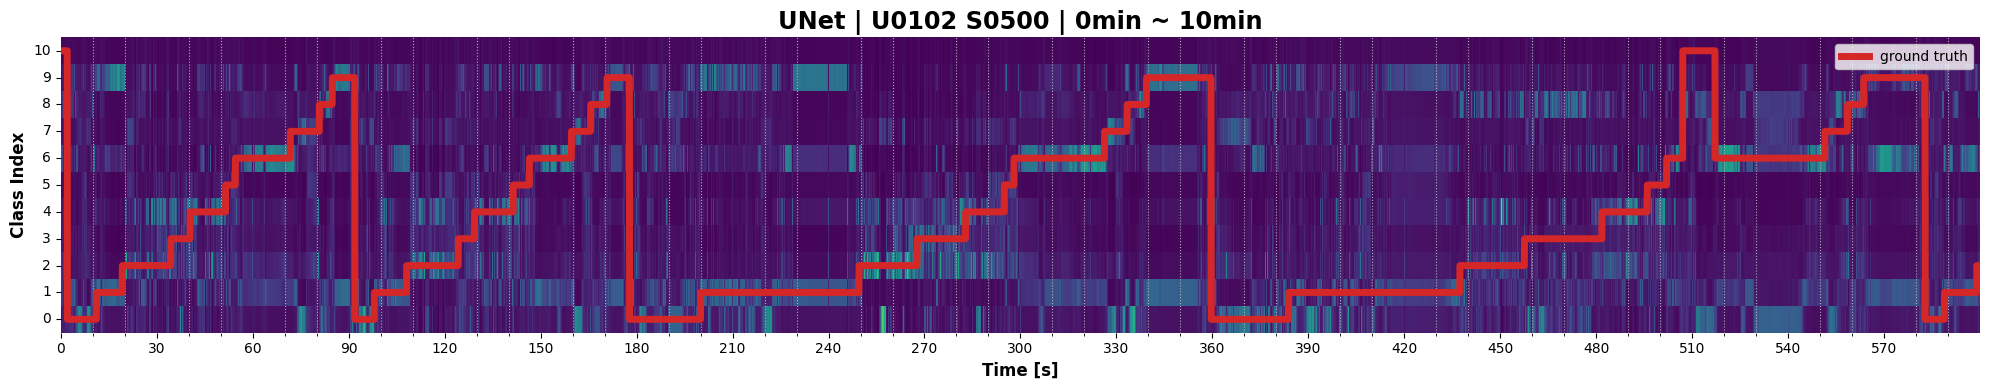

In [ ]:
samples = (0, 10)

fig = plot_timeline(samples, t_idx, y_softmax, title_prefix=f"{cfg.model.name} | {user} {session}")
fig.show()

prob=(11, 18000) pred=(18000,), gt=(18000,)


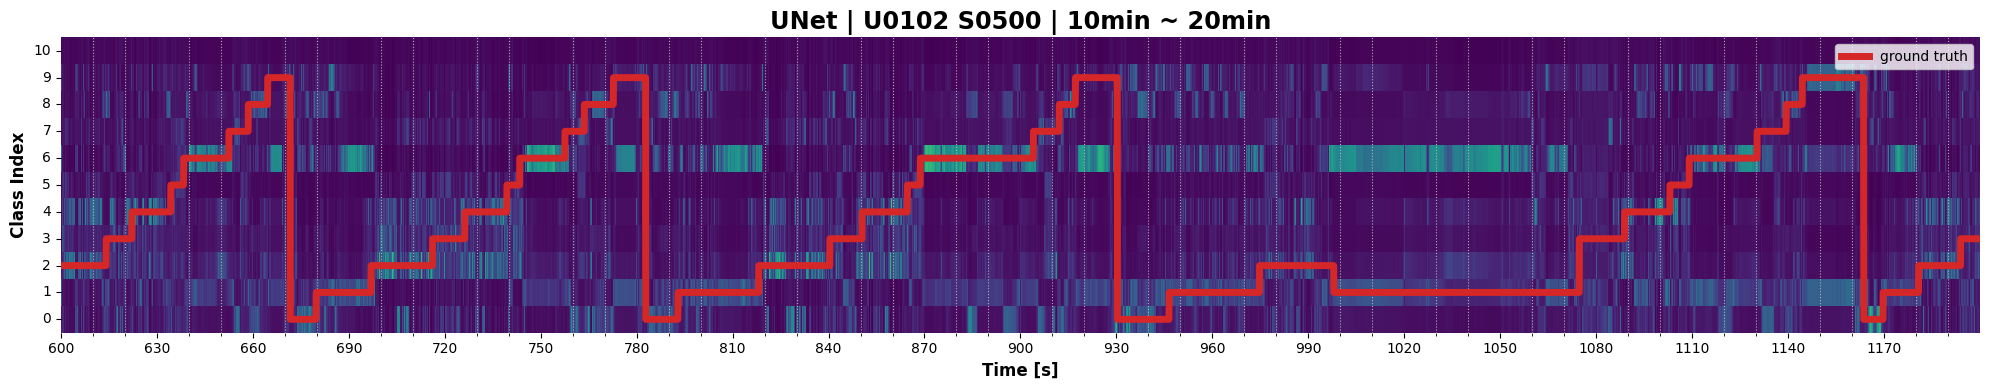

In [ ]:
samples = (10, 20)

fig = plot_timeline(samples, t_idx, y_softmax, title_prefix=f"{cfg.model.name} | {user} {session}")
fig.show()

## [5] Submission

`optk.codalab.construct_submission_dict()` can be used to make submission files to codalab.
The parameter is almost the same as `optk.codalab.eval_operation_segmentation_wrapper()` (used for evaluation), but groundtruth field (`t_idx`) is exclided.

### 5-1: Get prediction for test data.

In [ ]:
cfg.mode = "submission"
datamodule.setup("submission")
dataloaders = datamodule.submission_dataloader()
split = cfg.dataset.split.submission

outputs = dict()
for i, dataloader in enumerate(dataloaders):
    user, session = split[i]
    logger.info(f"test on {user}-{session}")

    trainer.test(plmodel, dataloader)

    # save model outputs
    pred_dir = Path(
        cfg.path.logdir.predict.format(user=user, session=session)
    )
    pred_dir.mkdir(parents=True, exist_ok=True)

    for key, arr in plmodel.test_results.items():
        path = Path(pred_dir, f"{key}.npy")
        np.save(path, arr)
        logger.info(f"save {key}[shape={arr.shape}] to {path}")

    outputs[f"{user}-{session}"] = {
        "y": plmodel.test_results.get("y"),
        "unixtime": plmodel.test_results.get("unixtime"),
    }
    plmodel.clear_test_outputs()

INFO:openpack_torch.data.datamodule:dataset[train]: None
2024-02-04 06:59:48 | INFO | openpack_torch.data.datamodule | dataset[train]: None
INFO:openpack_torch.data.datamodule:dataset[val]: None
2024-02-04 06:59:48 | INFO | openpack_torch.data.datamodule | dataset[val]: None
INFO:openpack_torch.data.datamodule:dataset[test]: None
2024-02-04 06:59:48 | INFO | openpack_torch.data.datamodule | dataset[test]: None
INFO:openpack_torch.data.datamodule:dataset[submission]: {'U0102-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7c5bf15881f0>}
2024-02-04 06:59:48 | INFO | openpack_torch.data.datamodule | dataset[submission]: {'U0102-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7c5bf15881f0>}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please b

Testing: |          | 0/? [00:00<?, ?it/s]

INFO:__main__:save t[shape=(93, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/RUN0/pred/last/U0102-S0500/t.npy
2024-02-04 06:59:49 | INFO | __main__ | save t[shape=(93, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/RUN0/pred/last/U0102-S0500/t.npy
INFO:__main__:save y[shape=(93, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/RUN0/pred/last/U0102-S0500/y.npy
2024-02-04 06:59:49 | INFO | __main__ | save y[shape=(93, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-iot/UNet/adam-exp/LR0.001/RUN0/pred/last/U0102-S0500/y.npy
INFO:__main__:save unixtime[shape=(93, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/debug-split/atr02-io

### 5-2: Make submission zip file

In the `construct_submission_dict()`, following processing will be done.

- Convert a predcition tesor `y` (3D array of logits) into a sequence of predicted class ids.
- Resample sequence into 1 Hz.
- Exclude the segments that is out of range for the evaluation protocol (i.e., unlabeled or null segments).

In the `make_submission_zipfile()`, following processing will be done.

- extract `prediction` and `unixtime` field
- generate `submission.json` and `submission.zip` to `output_dir`.

In [ ]:
output_dir = str(cfg.path.logdir.rootdir)

submission_dict = construct_submission_dict(outputs, ActSet(OPENPACK_OPERATIONS))
make_submission_zipfile(submission_dict, output_dir)

### 5-3: Submit to codalab and get results!

Now, you got a submission zip file (`./submission.zip`).
Let's upload it in the competition site (codalab) and get your score!

NOTE: If you are useing `optk.configs.datasets.splits.DEBUG_SPLIT` (default of this notebook), please use a submission form for "Development Phase".